# 19 - 评估因果模型

在绝大多数关于因果性的资料中，研究者使用合成数据来检验他们的方法是否有效。就像我们在《当预测失效时》那一章中所做的那样，他们同时生成 $Y_{0i}$ 和 $Y_{1i}$ 的数据，以便检查他们的模型是否正确捕捉到了处理效应 $Y_{1i} - Y_{0i}$。这在学术研究中完全可以，但在现实世界中我们没有这样的奢侈。当在工业界应用这些技术时，我们会一次又一次地被要求证明为什么我们的模型更好、为什么它应该替换生产环境中的现有模型，或者为什么它不会惨败。这一点如此关键，以至于我难以理解为什么几乎看不到任何材料解释我们应该如何用真实数据评估因果推断模型。

其结果是，想要应用因果推断模型的数据科学家很难说服管理层信任他们。他们采取的方式是展示理论多么严谨，以及在训练模型时多么谨慎。不幸的是，在以训练/测试划分范式为常态的世界里，这样的方式是远远不够的。模型的质量必须基于比精美理论更为具体的东西。想想看，机器学习之所以取得巨大成功，正是因为预测模型的验证非常直接。看到预测与实际发生的情况相符令人安心。

然而，在因果推断中，要实现类似训练/测试范式并不明显。这是因为因果推断关注的是估计一个不可观察的量，$\frac{\delta y}{ \delta t}$。既然我们看不见它，我们怎么知道模型在估计它方面是否表现良好？请记住，这就好像每个实体都有一个内在的响应度，由从处理到结果的直线斜率表示，但我们无法测量它。

![img](./images/19/sneak.png)

这一点非常非常难以理解，我花了多年才找到一种接近答案的东西。它不是终极答案，但在实践中有效，并且具有那种具体性，我希望它能把因果推断带向类似于我们在机器学习中拥有的训练/测试范式。这一技巧是使用敏感度的聚合测度。即使你不能逐一估计敏感度，你也可以对一组单位估计它，这正是我们将在这里利用的。


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

在本章中，我们将使用非随机数据来估计我们的因果模型，并用随机数据来评估它。我们仍然讨论价格如何影响冰淇淋销量。正如我们将看到的，随机数据对于评估非常宝贵。然而在现实中，收集随机数据往往代价高昂（如果你知道某些价格并不好，只会让你亏钱，为什么还要随机定价呢？）。结果就是我们经常拥有大量处理**非随机**的数据，而随机数据则少之又少。如果有任何随机数据，由于使用非随机数据来评估模型极其棘手，我们通常会把这些随机数据留作评估用途。

如果你忘记了，下面是数据的样子。


In [6]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


为了有可比较的对象，让我们训练两个模型。第一个将是带有交互项的线性回归，这样就允许不同单位之间的敏感度变化。

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i \, price_i + e_i
$$

一旦我们拟合了这个模型，我们就能够做出敏感度预测

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$


In [10]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

第二个模型将是完全非参数的机器学习预测模型

$$
sales_i = G(X_i, price_i) + e_i
$$


In [13]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

为了确保模型没有严重过拟合，我们可以检查在训练数据和新的未见数据上的 $R^2$。（对于那些熟悉机器学习的人，请注意，由于存在概念漂移，性能下降是预期的。模型是在价格非随机的数据上训练的，但测试集只包含随机化价格。）


In [16]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447709


在训练好我们的模型之后，我们将从回归模型中得到敏感度。同样，我们将采用数值近似

$$
\frac{\delta y(t)}{\delta t} \approx \frac{y(t+h) - y(t)}{h}
$$

我们的模型是在非随机数据上训练的。现在我们转向随机数据进行预测。为了方便，我们将机器学习模型的预测和因果模型的敏感度预测添加到一个单一的数据框 `prices_rnd_pred` 中。

此外，让我们还包括一个随机模型。这个模型的思想是它仅输出随机数作为预测。它显然不是很有用，但可以作为一个基准。当我们谈论新的评估方法时，我总喜欢想一想一个随机（无用）模型的表现。如果随机模型在评估指标上表现良好，这说明评估方法本身的有效性值得怀疑。


In [19]:
def predict_sensitivity(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


## 按模型分段的敏感度

现在我们已经有了预测，需要评估它们有多好。请记住，我们无法观察敏感度，因此没有简单的真实值可以比较。相反，让我们回想一下我们期望从敏感度模型中获得什么。也许这能为我们提供关于如何评估它们的一些洞见。

构建处理敏感度模型的想法源于寻找哪些单位对处理更敏感、哪些单位对处理不那么敏感的需求。这源于个性化的愿望。也许某个营销活动只对某一个人口细分极为有效；也许折扣只对某类客户奏效。一个好的因果模型应该帮助我们发现哪些客户对拟议的处理反应更好，哪些更差。它们应能根据单位对处理的弹性或敏感度将其分开。在我们的冰淇淋例子中，该模型应当能够判断哪些天人们愿意在冰淇淋上花更多钱，或者说哪些天价格敏感度不那么负。

如果这是我们的目标，那么如果我们能以某种方式按敏感度高到低对单位排序将非常有用。既然我们有预测的敏感度，我们可以用该预测对单位进行排序，并希望它也按照真实敏感度排序。遗憾的是，我们不能在单个单位层面评估这种排序。但如果我们不需要这样做呢？如果我们转而评估由排序定义的群组呢？如果我们的处理是随机分配的（这就是随机性的作用所在），估计一组单位的敏感度就很容易。我们所需要的只是比较处理组和未处理组之间的结果。

为了更好地理解这一点，把情形想象成二元处理案例更容易。继续用定价的例子，不过现在处理是折扣。换句话说，价格要么高（未处理），要么低（处理）。我们在 Y 轴上绘制销售量，在 X 轴上绘制我们的每个模型，并用颜色表示价格。然后，我们可以在模型轴上将数据分成三个等大小的组。**如果处理是随机分配的**，我们可以很容易地为每个组估计平均处理效应 $E[Y|T=1] - E[Y|T=0]$。

![img](./images/19/ate_bins.png)

在图中，我们可以看到第一个模型在预测销售方面还不错（与销售高度相关），但它产生的分组具有大致相同的处理效应，如底部的图所示。三个分段中的两个具有相同的敏感度，只有最后一个不同，敏感度较低。

另一方面，第二个模型产生的每个组都有不同的因果效应。这表明该模型的确可以用于个性化。最后，随机模型产生的组具有完全相同的敏感度。这并不十分有用，但也是预料之中的。如果模型是随机的，它产生的每个分段都将是数据的随机代表性样本。所以其组内的敏感度应该和整个数据集的平均处理效应大致相同。

仅通过观察这些图，你就可以对哪个模型更好形成直观印象。敏感度看起来越有序、不同分段之间差异越大，模型越好。在这里，模型2可能优于模型1，而模型1又优于随机模型。

为了推广到连续处理的情况，我们可以使用单变量线性回归模型来估计敏感度：

$$
y_i = \beta_0 + \beta_1 t_i + e_i
$$

如果我们在某个组的样本上运行该模型，我们将估计该组内的敏感度。

根据简单线性回归理论，我们知道

$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

其中 $\bar{t}$ 是处理的样本均值，$\bar{y}$ 是结果的样本均值。下面是其在代码中的样子


In [22]:
@curry
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

现在让我们将这应用于我们的冰淇淋价格数据。为此，我们还需要一个函数将数据集划分为等大小的区间，并对每个区间应用敏感度函数。下面的代码可以处理这一点。


In [25]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))) # estimate the sensitivity on each partition

最后，让我们使用之前的预测绘制按区间划分的敏感度。这里，我们将使用每个模型来构建分区，然后在每个分区上估计敏感度。


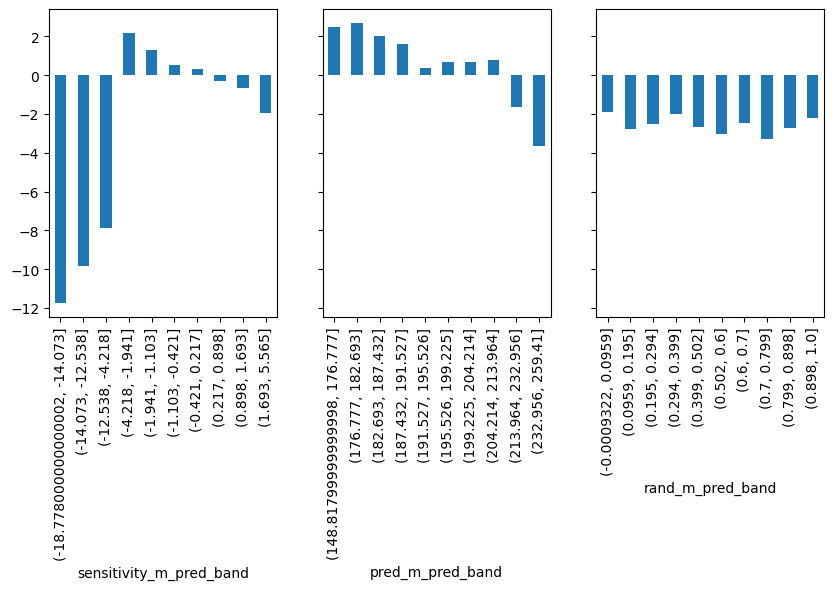

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)


首先看随机模型（`rand_m`）。在它的每个分区中，估计的敏感度大致相同。从图上我们已经可以看到，它对个性化没有太大帮助，因为它无法区分高价格敏感日和低价格敏感日。接下来考虑预测模型 `pred_m`。这个模型实际上很有希望！它能构建一些敏感度高的组和一些敏感度低的组。这正是我们需要的。

最后，因果模型 `sensitivity_m` 看起来有些奇怪。它识别出一些极低敏感度的组，这里的“低”实际上意味着高价格敏感度（当我们提高价格时销售会大幅下降）。识别这些高价格敏感的日子对我们非常有用。如果我们知道它们是哪些日子，就可以避免在这类日子上调价。该因果模型也能识别出一些较不敏感的区域，因此它可以成功地区分高敏感和低敏感，但其排序并不如预测模型那样好。

那么我们应该如何决定？哪个更有用？预测模型还是因果模型？预测模型的排序更好，但因果模型可以更好地识别极端情况。按区间绘制敏感度是一个好的初步检查，但它无法精确回答哪个模型更好。我们需要转向更复杂的东西。

## 累积敏感度曲线

再次考虑将价格转换为二元处理的示例。我们从之前停下的地方开始，因此我们得到了按区间的处理敏感度。接下来我们可以做的是根据区间的敏感度对它们重新排序。也就是说，我们把最敏感的组放在第一位，第二敏感的放在第二位，如此类推。对于模型1和3，不需要重新排序，因为它们已经是按序排列的。对于模型2，我们需要反向排序。

一旦我们有了这些有序的分组，我们就可以构建所谓的累积敏感度曲线。我们首先计算第一组的敏感度；然后计算第一组和第二组的合并敏感度，以此类推，直到包含所有组。最终，我们将得到整个数据集的敏感度。下面是在示例中的样子。

![img](./images/19/cumm_elast.png)

注意，累积敏感度曲线的第一个区间只是该模型认为最敏感组的平均处理效应。同时，对于所有模型，累积敏感度最终都会收敛到同一点，即整个数据集的平均处理效应。

在数学上，我们可以将累积敏感度定义为到第 $k$ 个单位为止估计的敏感度：

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_{i=1}^k (t_i - \bar{t})(y_i - \bar{y})}{\sum_{i=1}^k (t_i - \bar{t})^2}
$$

为了绘制累积敏感度曲线，我们在数据集上迭代运行上述函数，以产生以下序列：

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

这一序列在模型评估方面非常有趣，因为我们可以对其做出偏好判断。首先，一个模型越好，满足

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

的程度越高，对于任意的 $k$ 和 $a>0$。用通俗的话说，如果一个模型善于对敏感度排序，那么在前 $k$ 个样本中观察到的敏感度应高于在前 $k+a$ 个样本中观察到的敏感度。换句话说，如果我看排名靠前的单位，它们应该比下面的单位有更高的敏感度。

其次，一个模型越好，满足

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

尽可能大的程度越高，对于任意 $k$ 和 $a>0$。直觉是，我们不仅希望前 $k$ 个单位的敏感度高于它们下面的单位，而且希望这种差异尽可能大。

为了使这更具体，下面用代码表示这一思想。


In [31]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

关于这个函数，需要注意几点。它假设用于排序敏感度的指标存储在 `prediction` 参数所指定的列中。此外，第一个分组包含 `min_periods` 个单位，因此它可以与其他分组不同。原因是由于样本量小，曲线开头的敏感度可能太噪声。为了解决这个问题，我们可以选择一个足够大的初始分组。最后，`steps` 参数定义了每个后续分组中包含的额外单位数量。

有了这个函数，我们就可以根据每个模型产生的排序绘制累积敏感度曲线。


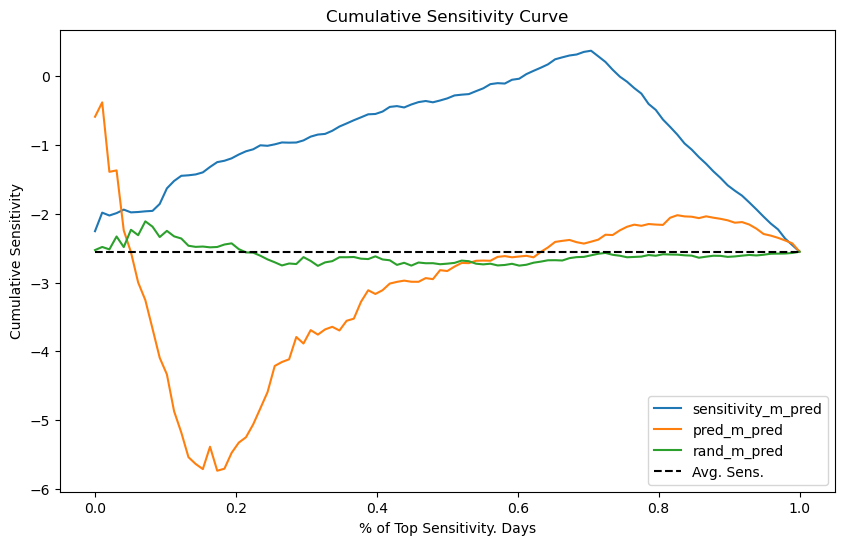

In [34]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

解释累积敏感度曲线可能有点挑战，不过我是这样理解的。再次说，考虑二元处理的情况可能更容易。曲线的 X 轴表示我们处理的样本比例。这里，我把这一轴规范化为数据集的比例，所以 0.4 表示我们正在处理 40% 的样本。Y 轴是我们在这么多样本上应期望的敏感度。因此，如果曲线在 40% 处的值为 -1，意味着排名前 40% 单位的敏感度是 -1。理想情况下，我们希望在最大的样本比例上具有最高的敏感度。于是，理想的曲线应从 Y 轴高处开始，并非常缓慢地下降到平均敏感度，表示我们可以处理很大比例的单位，同时仍保持高于平均的敏感度。

不用说，我们的任何模型都没有接近理想的敏感度曲线。随机模型 `rand_m` 在平均敏感度附近震荡，且从不远离它。这意味着该模型无法找到敏感度不同于平均值的组。至于预测模型 `pred_m`，它似乎以相反的顺序排列敏感度，因为曲线从低于平均敏感度开始。不仅如此，它还很快（大约在50%的样本处）收敛到平均敏感度。最后，因果模型 `sensitivity_m` 看起来更有趣。起初它有一种奇怪的行为，累积敏感度先远离平均值增加，但随后达到一个点，我们可以处理大约 75% 的单位，同时保持相当不错的敏感度（接近 0）。这很可能是因为该模型能够识别出非常低敏感度（高价格敏感度）的日子。因此，只要我们在这些日子不提价，我们就可以在大多数样本（约 75%）中提价，同时仍保持低价格敏感度。

在模型评估方面，累积敏感度曲线已经比单纯的按区间敏感度概念好得多。在这里，我们能够更精确地给出对模型的偏好陈述。但这仍然是一条难以理解的曲线。因此，我们可以做进一步的改进。


## 累积增益曲线

接下来的想法是在累积敏感度之上进行一种非常简单但强大的改进。我们将累积敏感度乘以样本比例。例如，如果在 40% 的位置上累积敏感度是 -0.5，那么在那里我们会得到 -0.2（-0.5 * 0.4）。然后，我们将其与随机模型产生的理论曲线进行比较。这条曲线实际上是从 0 到平均处理效应的一条直线。可以这样理解：随机模型的每一个累积敏感度点都是平均处理效应，因为模型只是产生数据的随机代表性分割。如果我们沿 (0,1) 线的每个点将平均处理效应乘以该点，我们就会得到一条从零到平均处理效应的直线。

![img](./images/19/cumm_gain.png)

一旦我们有了理论随机曲线，我们就可以将其作为基准，与其他模型进行比较。所有曲线都从同一点开始并结束于同一点。然而，模型越善于排序敏感度，其曲线在 0 到 1 之间的部分就会越偏离随机直线。例如，在上图中，模型 M2 比 M1 更好，因为它在接近平均处理效应的终点之前偏离得更多。对于熟悉 ROC 曲线的人来说，可以把累积增益看作因果模型的 ROC。

从数学上说，

$$
\widehat{F(t)}_k = \hat{\beta_1}_k \times \frac{k}{N} = \dfrac{\sum_{i=1}^k (t_i - \bar{t})(y_i - \bar{y})}{\sum_{i=1}^k (t_i - \bar{t})^2} \times \frac{k}{N}
$$

在代码中实现它，我们所需做的只是加入样本比例的归一化。


In [38]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

对于我们的冰淇淋数据，我们将得到以下曲线。


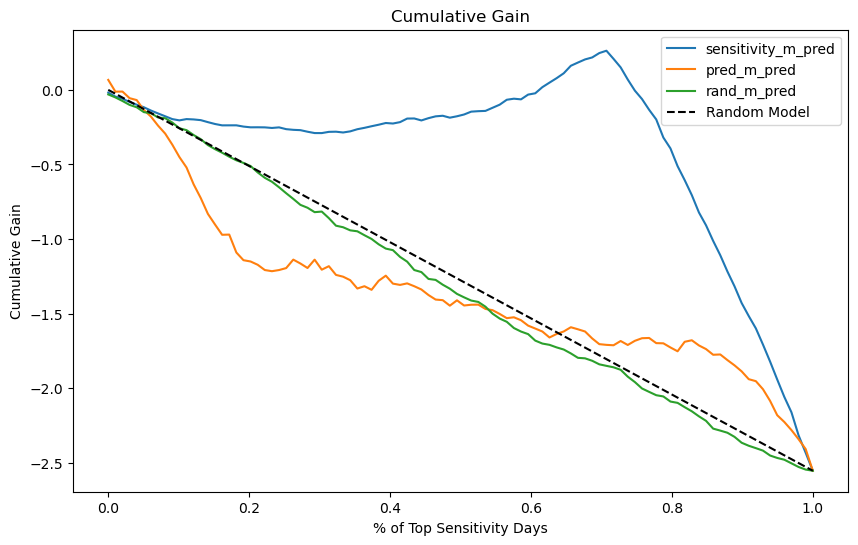

In [41]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

现在很明显，因果模型（`sensitivity_m`）比另外两个模型好得多。它与随机曲线的偏离程度远大于 `rand_m` 和 `pred_m`。还要注意实际的随机模型是如何非常贴近理论随机模型的，它们之间的差异很可能只是随机噪声。

至此，我们涵盖了一些关于如何评估因果模型的很好的想法。仅此一点就意义重大。我们成功地评估了模型在排序敏感度方面的优劣，即便没有真实的敏感度可供比较。还有唯一缺失的一点是，在这些测量周围加上置信区间。毕竟，我们总不能这么野蛮吧？

![img](./images/19/uncivilised.png)

## 考虑方差

当我们处理敏感度曲线时，不考虑方差显得有些不对劲。尤其是因为所有这些曲线都使用了线性回归理论，因此在它们周围加入置信区间应该相当容易。

为此，我们首先创建一个函数，用于返回线性回归参数的置信区间。我这里使用的是简单线性回归的公式，但你完全可以按你喜欢的方式计算置信区间。

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$


In [44]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

通过对我们的 `cumulative_sensitivity_curve` 函数做一些小的修改，我们可以输出敏感度的置信区间。


In [47]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

最后，这里是因果模型的 95% 置信区间的累积敏感度曲线。


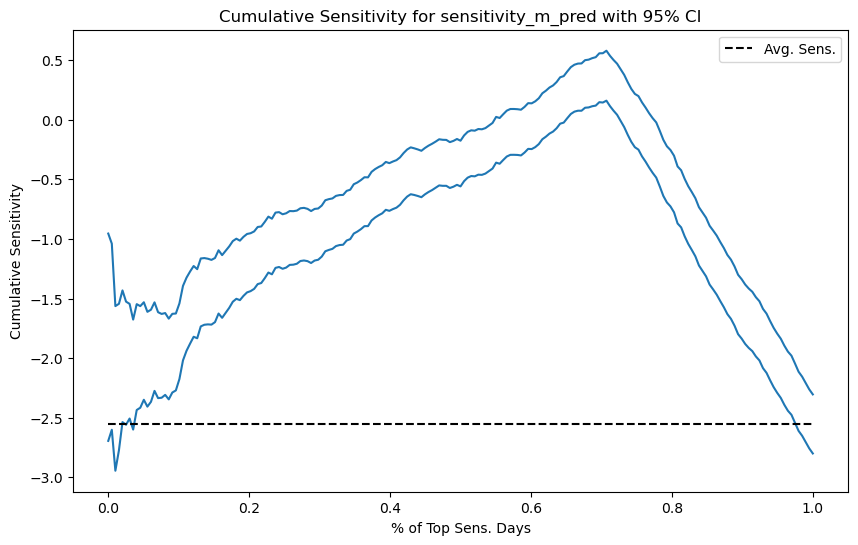

In [50]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

注意，随着我们累积更多的数据集，置信区间变得越来越小。这是因为样本量在增加。

至于累积增益曲线，得到其置信区间也同样简单。同样，我们只需将调用 `sensitivity` 函数替换为调用 `sensitivity_ci` 函数即可。


In [53]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

下面是因果模型的情况。请注意，现在即便在曲线开始时样本量较小，置信区间也从较小值开始。这是因为归一化因子 $\frac{k}{N}$ 会缩小平均处理效应及其置信区间。由于这条曲线用于比较模型，这不应成为问题，因为这一缩小因子将同等地作用于所有被评估的模型。


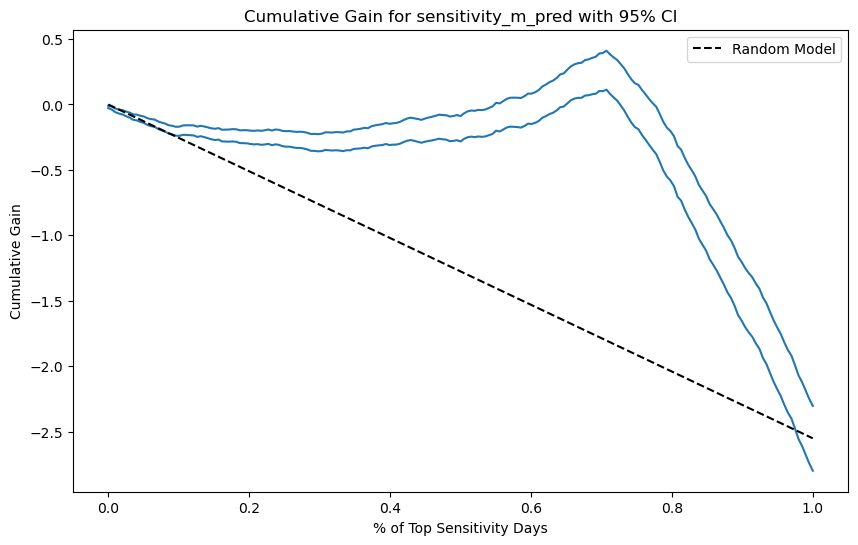

In [56]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();

## 关键观点

在这里我们看到了三种检查模型在排序敏感度方面优劣的方法。我们利用这些方法来比较具有因果目的的模型并进行选择。这是一件大事。即使看不到真正的敏感度，我们也设法评估了模型在识别不同敏感度群体方面的好坏！

在这里，我们高度依赖随机数据。我们在非随机数据上训练模型，但所有评估都是在处理已被随机化的样本上完成的。这是因为我们需要某种可信赖的方法来估计敏感度。如果没有随机数据，我们这里使用的简单公式将不起作用。我们现在很清楚，简单线性回归在存在混杂变量时会有遗漏变量偏差。

不过，如果我们能拿到一些随机数据，我们已经知道如何比较随机模型。在下一章中，我们将解决非随机数据的问题，但在此之前，我想在模型评估方面再说几句。

让我们重申可信模型评估的重要性。有了累积增益曲线，我们终于有了一个很好的方法来比较用于因果推断的模型。我们现在可以决定哪个模型更适合用于处理个性化。这是一个重大进步。你会发现，大多数关于因果推断的资料并没有提供一种好的模型评估方法。在我看来，这是让因果推断像机器学习一样流行所缺失的那一块。有了好的评估，我们可以让因果推断更接近已经在预测模型中如此有用的训练/测试范式。这是一个大胆的说法。我在说这话时很谨慎，但目前为止我还没有发现对它的有力批评。如果你有，请告知。

## 参考说明

本章内容主要基于作者个人的经验总结，许多观点和方法源自实践中的体会。因此，无法提供严格意义上的学术参考文献。与正规科研工作不同，这些内容没有经过系统性的学术审查，也未经过同行评议与理论论证。读者或许会注意到，本文更多讨论的是“实践中有效的方法”，而非详细阐述其背后的理论基础。这种方法可以被视为“来自一线的经验科学”（a sort of science from the streets）。尽管如此，既然这些内容已公开发布，也非常欢迎批评与反馈——如果读者发现其中有明显错误或不妥之处，欢迎提出 issue，作者会尽力回应。

最后，对于那些希望系统学习机器学习的读者，作者也意识到本章的讲解可能过于简略。坦率地说，作者认为自己真正能够贡献价值的领域是因果推断的教学，而非机器学习。机器学习领域已有大量优质的公开资源，远超作者所能提供的内容。其中的经典之作，就是 [Andrew Ng 的机器学习课程](https://www.coursera.org/learn/machine-learning)，如果读者是机器学习初学者，作者强烈推荐认真学习这门课程。


## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。
